In [1]:
#!pip install pycrf
#!pip install sklearn-crfsuite

In [2]:
import spacy
import re
import sklearn_crfsuite
from sklearn_crfsuite import metrics

nlp = spacy.load('en_core_web_sm')

#  1. Data Processing
---

As you are already aware that the dataset is in the token format instead of sentences, you need to construct the sentences from the words. There are blank lines after the completion of each sentence or a set of labels in label files ('train_label' and 'test_label') and you need to build a logic to arrange them into sentences or a sequence of labels in the case of label files. You can refer to the following two images to understand this better.

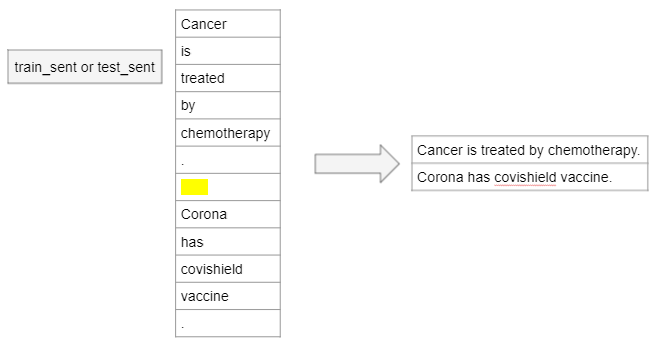

A similar step is to be performed for the 'train_label' and 'test_label' datasets.

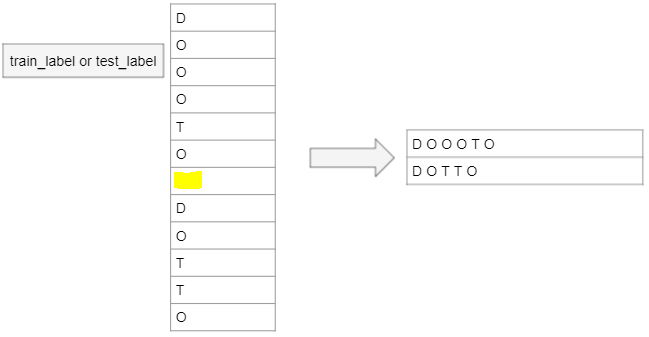

## You need to do the following three tasks after processing and modifying the datasets:

>   Construct proper sentences from individual words and print five sentences along with their labels.

>   Print the correct count of the number of sentences in the processed train and test dataset.

>   Correctly count the number of lines of labels in the processed train and test dataset.

In [3]:
def buildSentences(data,seperator):
    documnts = []
    sentences =[]
    documnts.append(data.split(seperator))
    # Remove the last element which is empty
    documnts[-1].pop()
    sentences = list(map(lambda x : x.replace('\n',' ').strip(),documnts[0]))
    return sentences

### Count the number of sentences in the processed train and test dataset 

In [4]:
# Read train and test dataset

with open('Dataset\\train_sent', 'r') as train_sent:
    train_data = train_sent.read()
with open('Dataset\\test_sent','r') as test_sent:
    test_data = test_sent.read()
    

In [5]:
# Count of sentences in train dataset
train_data_processed = buildSentences(train_data,'\n\n')
print(f'count of sentences in train dataset { len(train_data_processed) }')

count of sentences in train dataset 2599


In [6]:
# Count of sentences in test dataset
test_data_processed = buildSentences(test_data,'\n\n')
print(f'count of sentences in test dataset { len(test_data_processed) }')

count of sentences in test dataset 1056


### Count the number of lines of labels in the processed train and test dataset.

In [7]:
# Read train and test labels dataset
with open('Dataset\\train_label','r') as train_label:
    train_label = train_label.read()
with open('Dataset\\test_label','r') as test_label:
    test_label = test_label.read() 

In [8]:
# Count number of lines in train label
processed_trains_label = buildSentences(train_label, '\n\n')
print(f'count of lines in train labels file { len(processed_trains_label) }')

count of lines in train labels file 2599


In [9]:
# Count number of lines in test label
processed_test_label = buildSentences(test_label, '\n\n')
print(f'count of lines in test labels file { len(processed_test_label) }')

count of lines in test labels file 1056


In [10]:
# Print first 5 sentences in train dataset
for i in range(25):
  print("Sentence:", train_data_processed[i])
  print("Labels:", processed_trains_label[i], "\n\n")

Sentence: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Labels: O O O O O O O O O O O O O O O 


Sentence: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


Sentence: Arrest of dilation was the most common indication in both `` co

#2. Concept Identification
---

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 

In [11]:
import pandas as pd

In [12]:
dataset = train_data_processed + test_data_processed
noun_pos_list = []
for sent in dataset:
    doc = nlp(sent)
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN']:
            pos = token.pos_
            word = token.text
            noun_pos_list.append((word,pos))
        

In [13]:
# Convert the list to a dataframe
df = pd.DataFrame(noun_pos_list, columns=['Word', 'POS'])
print(df.head(10))

         Word    POS
0      births   NOUN
1       weeks   NOUN
2  University  PROPN
3     Vermont  PROPN
4    delivery   NOUN
5       route   NOUN
6  indication   NOUN
7         age   NOUN
8      parity   NOUN
9    practice   NOUN


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [14]:

# Top 25 most frequent nouns
top_25_nouns = df['Word'].value_counts().head(25)
print(top_25_nouns)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
risk             71
surgery          71
cases            71
analysis         70
rate             67
response         66
survival         65
children         64
Name: Word, dtype: int64


#3.  Defining features for CRF
---

>   1.Define the features with the PoS tag as one of the features.


>   2.While defining the features in which you have used the PoS tags, you also need to consider the preceding word of the current word. The use of the information of the preceding word makes the CRF model more accurate and exhaustive.


>   3.Mark the beginning and the end words of a sentence correctly in the form of features.

### Define featues that will extract informaion about the words and the sentences.

|       Feature         |            Description         |
|-----------------------|--------------------------------|
|Word normalization     |Lemma of the Named Entity|
|Contextual Features    |2 preeeceding words and 2 successing word|
|POS                    |POS of the current word and one previous word|
|Orthographic Features  | Is the word in uppercase,lowercase, starts with upper case,alpha numeric,all numbers,last three char, last two  char|

                             



In [15]:
# POS tags
token_sent = nlp("".join(train_data_processed[:4]))
for token in token_sent:
    print(token.text, token.pos_)


All DET
live ADJ
births NOUN
> X
or CCONJ
= PRON
23 NUM
weeks NOUN
at ADP
the DET
University PROPN
of ADP
Vermont PROPN
in ADP
1995 NUM
( PUNCT
n CCONJ
= SYM
2395 NUM
) PUNCT
were AUX
retrospectively ADV
analyzed VERB
for ADP
delivery NOUN
route NOUN
, PUNCT
indication NOUN
for ADP
cesarean ADJ
, PUNCT
gestational ADJ
age NOUN
, PUNCT
parity NOUN
, PUNCT
and CCONJ
practice NOUN
group NOUN
( PUNCT
to PART
reflect VERB
risk NOUN
status NOUN
) PUNCT
The DET
total ADJ
cesarean ADJ
rate NOUN
was AUX
14.4 NUM
% NOUN
( PUNCT
344 NUM
of ADP
2395 NUM
) PUNCT
, PUNCT
and CCONJ
the DET
primary ADJ
rate NOUN
was AUX
11.4 NUM
% NOUN
( PUNCT
244 NUM
of ADP
2144 NUM
) PUNCT
Abnormal ADJ
presentation NOUN
was AUX
the DET
most ADV
common ADJ
indication NOUN
( PUNCT
25.6 NUM
% NOUN
, PUNCT
88 NUM
of ADP
344 NUM
) PUNCT
The DET
` PUNCT
` PUNCT
corrected VERB
'' PUNCT
cesarean ADJ
rate NOUN
( PUNCT
maternal ADJ
- PUNCT
fetal ADJ
medicine NOUN
and CCONJ
transported VERB
patients NOUN
excluded VERB
) PUNCT


In [16]:
# Let's define the features to get the feature value for one word.


def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
  pos_tags = []

  # We have to calculate POS tags for each word in the sentence
  token_sent = nlp(" ".join(sentence))
  for token in token_sent:
    pos_tags.append(token.pos_)
 

  
  #Define 12 features with PoS tag as one of the features
  features = [
    'word.lower=' + word.lower(),  # word in lowercase
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    #pos of the word
    'word.pos=' + pos_tags[pos]

  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence
  return features



#  4. Getting the features words and sentences
---

In [17]:
# Get Feature for a sentence
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, position) for position in range(len(sentence_list))]

In [18]:
# Checking feature extraction
example_sentence = train_data_processed[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[:3]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


[['word.lower=cesarean',
  'word[-3:]=ean',
  'word[-2:]=an',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.pos=ADJ',
  'BEG'],
 ['word.lower=rates',
  'word[-3:]=tes',
  'word[-2:]=es',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=NOUN',
  'prev_word.lower=cesarean',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.pos=ADJ'],
 ['word.lower=at',
  'word[-3:]=at',
  'word[-2:]=at',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=ADP',
  'prev_word.lower=rates',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=False',
  'prev_word.pos=NOUN']]

#   5. Defining input and target variables
---

In [19]:
# define X_train, X_train is a feature matrix of every word in the entire train dataset. 
# We have now the functions created to convert word to feature and sentence to word.
# With this we can return a X_train matrix

X_train = [getFeaturesForOneSentence(doc) for doc in train_data_processed]


In [20]:
print(X_train[0])


[['word.lower=all', 'word[-3:]=All', 'word[-2:]=ll', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=True', 'word.pos=DET', 'BEG'], ['word.lower=live', 'word[-3:]=ive', 'word[-2:]=ve', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=ADJ', 'prev_word.lower=all', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=True', 'prev_word.pos=DET'], ['word.lower=births', 'word[-3:]=ths', 'word[-2:]=hs', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=NOUN', 'prev_word.lower=live', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=ADJ'], ['word.lower=>', 'word[-3:]=>', 'word[-2:]=>', 'word.isupper=False', 'word.isdigit=False', 'word.startsWithCapital=False', 'word.pos=X', 'prev_word.lower=births', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_word.startsWithCapital=False', 'prev_word.pos=NOUN'], ['word

In [21]:
# Build X_test
X_test = [getFeaturesForOneSentence(doc) for doc in test_data_processed]


In [22]:
# Define a function to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [23]:
# Now we build Y_train and Y_test
# Y is the labels

Y_train = [getLabelsInListForOneSentence(doc) for doc in processed_trains_label]
Y_test = [getLabelsInListForOneSentence(doc) for doc in processed_test_label]


In [24]:
print(Y_train[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [25]:
# Verify our X and Y metrices
print(f"Length of X_train: {len(X_train)}")
print(f"Length of Y_train: {len(Y_train)}")

Length of X_train: 2599
Length of Y_train: 2599


#   6. Building the CRF model
---

In [26]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [27]:
# Fit the training data in the model
crfmodel = sklearn_crfsuite.CRF(
    algorithm='l2sgd',
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)



In [28]:
len(Y_train[0])

45

In [29]:
crfmodel.fit(X_train, Y_train)

CRF(algorithm='l2sgd', all_possible_transitions=True, c2=0.1,
    max_iterations=100)

# 7. Evaluation
---

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [30]:
y_pred = crfmodel.predict(X_test)

In [31]:
# Example test sentence, test labels and predicted labels
print(test_data_processed[15], "\n\n")
print(processed_test_label[15], "\n\n")
print(y_pred[15])

The rate of severe preeclampsia was increased significantly in the triplet group 12 of 53 ( 22.6 % ) as compared with the twin group 3 of 53 ( 5.7 % ) ( OR = 4.9 , 95 % CI 1.2-23.5 , p = 0.02 ) 


O O O O D O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 


['O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [32]:
# Evaluate the model
metrics.flat_f1_score(Y_test,y_pred,average='weighted')

0.9130540652152024

#   8. Identifying the diseases and treatment using a custom NER
---

Create the code or logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset. You can refer to the following image to get an idea on how to create a dictionary where diseases are working as keys and treatments are working as values.
 

In [94]:
y_pred[1:5]

array([list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']),
       list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])],
      dtype=object)

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.
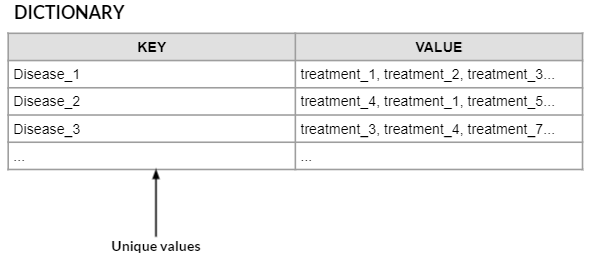

In [97]:
diseases_and_treatments =  {} # dictionary with disease as key an list of treatments as value

for i in range(len(y_pred)): # For each predicted sequence
  labels = y_pred[i]

  disease = ""
  treatment = ""

  for j in range(len(labels)): # for each individual label in the sequence
    if labels[j] == 'O': # ignore if label is O -- other
      continue

    if(labels[j] == 'D'): # Label D indicates disease, so add the corresponding word from test sentence to the disease name string
      disease += test_data_processed[i].split()[j] + " "
      continue

    if(labels[j] == 'T'): # Label T indicates disease, so add the corresponding word from test sentence to the treatment name string
      #print(test_sentences[i].split()[j])
      treatment += test_data_processed[i].split()[j] + " "

  disease = disease.strip() # to remove extraneous spaces
  treatment = treatment.strip()

  # add the identified disease and treatment to the dictionary
  # if it is a new disease, directly add the value
  # if the disease has been seen previously, get the treatment list
  # and add current treatment to the list.
  if disease != "" and treatment != "":
    if disease not in diseases_and_treatments.keys():
      diseases_and_treatments[disease] = [treatment]
    else:
      treatment_list = diseases_and_treatments.get(disease)
      treatment_list.append(treatment)
      diseases_and_treatments[disease] = treatment_list

In [99]:
diseases_and_treatments_df = pd.DataFrame(diseases_and_treatments.items(), columns=['Disease', 'Treatments'])
diseases_and_treatments_df.head(10)

,Disease,Treatments
0,hereditary retinoblastoma,[radiotherapy]
1,epilepsy,[Methylphenidate]
2,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
3,coronary-artery disease,[Antichlamydial antibiotics]
4,primary pulmonary hypertension ( PPH ),[fenfluramines]
5,essential hypertension,[moxonidine]
6,foot infection,[G-CSF treatment]
7,hemorrhagic stroke,[double-bolus alteplase]
8,cardiac disease,[fenfluramine-phentermine]
9,early Parkinson 's disease,[Ropinirole monotherapy]


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [100]:
# treatment of `hereditary retinoblastoma`

diseases_and_treatments_df[diseases_and_treatments_df['Disease'] == 'hereditary retinoblastoma']

,Disease,Treatments
0,hereditary retinoblastoma,[radiotherapy]
